In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd  /content/drive/MyDrive/HW2


[Errno 2] No such file or directory: '/content/drive/MyDrive/HW2'
/content


دانلود دیتاست فقط برای بار اول

In [4]:
# prompt: how to download file from https://drive.google.com/file/d/1f5FYQWZUKVSrroAz1_RkW2DrfHKj-tAZ/view?usp=drive_link and extract in  /content/drive/MyDrive/HW2

# Install gdown if not already installed
!pip install gdown

# Create the destination directory if it doesn't exist
!mkdir -p /content/drive/MyDrive/HW2

# Download the file using gdown
!gdown https://drive.google.com/uc?id=1f5FYQWZUKVSrroAz1_RkW2DrfHKj-tAZ -O /content/drive/MyDrive/HW2/downloaded_file.zip

# Change to the destination directory
%cd /content/drive/MyDrive/HW2

# Extract the contents of the zip file
!unzip downloaded_file.zip

# Remove the zip file after extraction (optional)
!rm downloaded_file.zip

# List the contents to see the extracted files
!ls -l

print("File downloaded and extracted successfully in /content/drive/MyDrive/HW2!")

Downloading...
From (original): https://drive.google.com/uc?id=1f5FYQWZUKVSrroAz1_RkW2DrfHKj-tAZ
From (redirected): https://drive.google.com/uc?id=1f5FYQWZUKVSrroAz1_RkW2DrfHKj-tAZ&confirm=t&uuid=21cde5bf-95a7-4bfc-833d-84ff4a7bdc42
To: /content/drive/MyDrive/HW2/downloaded_file.zip
100% 124M/124M [00:01<00:00, 69.9MB/s]
/content/drive/MyDrive/HW2
Archive:  downloaded_file.zip
  inflating: Data/test/adenocarcinoma/000108 (3).png  
  inflating: Data/test/adenocarcinoma/000109 (2).png  
  inflating: Data/test/adenocarcinoma/000109 (4).png  
  inflating: Data/test/adenocarcinoma/000109 (5).png  
  inflating: Data/test/adenocarcinoma/000112 (2).png  
  inflating: Data/test/adenocarcinoma/000113 (7).png  
  inflating: Data/test/adenocarcinoma/000114 (5).png  
  inflating: Data/test/adenocarcinoma/000114.png  
  inflating: Data/test/adenocarcinoma/000115 (4).png  
  inflating: Data/test/adenocarcinoma/000115 (8).png  
  inflating: Data/test/adenocarcinoma/000115.png  
  inflating: Data/test/

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [6]:
train_folder = "/content/drive/MyDrive/HW2/Data/train"
valid_folder = "/content/drive/MyDrive/HW2/Data/valid"
test_folder = "/content/drive/MyDrive/HW2/Data/test"

In [8]:
input_shape = (224,224,3)
num_classes = 4

# Image Data Generators for test

test_datagen = ImageDataGenerator(dtype='float32')


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle = False,
)


Found 315 images belonging to 4 classes.


In [9]:
!pip install wandb

# import necessary libraries

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import wandb
from sklearn.model_selection import KFold


# define the sweep configuration for hyperparameter tuning


In [11]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'valid_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.0001,
            'max': 0.01
        },
        'batch_size': {
            'values': [16, 32, 64]
        },
        'weight_decay': {
            'distribution': 'uniform',
            'min': 1e-5,
            'max': 1e-3
        },
        'dropout': {
            'distribution': 'uniform',
            'min': 0.1,
            'max': 0.5
        },
        'epochs': {
            'value': 10
        }
    }
}


# initialize the sweep


In [12]:
sweep_id = wandb.sweep(sweep_config, project="lung-cancer-classification")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 5thrxg2s
Sweep URL: https://wandb.ai/smf007smf007-/lung-cancer-classification/sweeps/5thrxg2s


# define transformations for the data with augmentation


In [13]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # random resized crop
    transforms.RandomHorizontalFlip(p=0.2),  # horizontal flip
    transforms.RandomVerticalFlip(p=0.2),  # vertical flip
    transforms.ColorJitter(contrast=(0.8, 1.2)),  # contrast adjustment
    transforms.RandomRotation(30),  # rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transformation for validation and test data
valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# define the cnn model with dropout


In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes=4, dropout=0.25):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout))
        self.fc = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


# define the training function


In [15]:
def train():
    # initialize a new wandb run
    with wandb.init() as run:
        # set seeds for reproducibility
        seed = 42
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # check if gpu is available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # get the configuration from wandb
        config = run.config

        # load datasets (replace train_folder, valid_folder, test_folder with actual paths)
        train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=train_transform)
        valid_dataset = torchvision.datasets.ImageFolder(root=valid_folder, transform=valid_test_transform)
        test_dataset = torchvision.datasets.ImageFolder(root=test_folder, transform=valid_test_transform)

        # initialize the model, loss function, and optimizer with l2 regularization
        model = CNN(num_classes=4, dropout=config.dropout).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=config.weight_decay)


        # early stopping

        class EarlyStopping:
            def __init__(self, patience=5, min_delta=0):
                self.patience = patience
                self.min_delta = min_delta
                self.counter = 0
                self.min_validation_loss = np.inf

            def __call__(self, validation_loss):
                if (self.min_validation_loss - validation_loss) > self.min_delta:
                    self.min_validation_loss = validation_loss
                    self.counter = 0
                elif (self.min_validation_loss - validation_loss) <= self.min_delta:
                    self.counter += 1
                    if self.counter >= self.patience:
                        return True
                return False

        early_stopping = EarlyStopping(patience=5, min_delta=0)



        # k-fold cross validation

        def train_model(train_loader, valid_loader):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            train_loss = running_loss / len(train_loader)

            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()
            valid_loss /= len(valid_loader)

            return train_loss, valid_loss


        kfold = KFold(n_splits=5, shuffle=True)
        train_losses, valid_losses = [], []

        for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_dataset)):
            print(f'FOLD {fold + 1}')
            train_sampler = SubsetRandomSampler(train_ids)
            valid_sampler = SubsetRandomSampler(valid_ids)

            train_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=train_sampler)
            valid_loader = DataLoader(train_dataset, batch_size=config.batch_size, sampler=valid_sampler)

            for epoch in range(config.epochs):
                train_loss, valid_loss = train_model(train_loader, valid_loader)
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)

                wandb.log({"epoch": epoch, "train_loss": train_loss, "valid_loss": valid_loss})

                print(f'Epoch {epoch+1}/{config.epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

                if early_stopping(valid_loss):
                    print("Early stopping triggered")
                    break



        # plot training and validation loss

        plt.plot(train_losses, label='Training Loss')
        plt.plot(valid_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


        # evaluate the model on the test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in DataLoader(test_dataset, batch_size=config.batch_size):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%')
        wandb.log({"test_accuracy": test_accuracy})



# run the sweep


wandb: Agent Starting Run: 21ezjlvc with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.3023095096803192
wandb: 	epochs: 10
wandb: 	learning_rate: 0.0005288918847759701
wandb: 	weight_decay: 0.0005567858582328733
wandb: Currently logged in as: smf007smf007 (smf007smf007-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


FOLD 1
Epoch 1/10, Train Loss: 1.3701, Valid Loss: 1.3423
Epoch 2/10, Train Loss: 1.2462, Valid Loss: 1.2616
Epoch 3/10, Train Loss: 1.0878, Valid Loss: 1.1686
Epoch 4/10, Train Loss: 1.0005, Valid Loss: 1.1184
Epoch 5/10, Train Loss: 0.9552, Valid Loss: 1.0354
Epoch 6/10, Train Loss: 0.9361, Valid Loss: 1.0289
Epoch 7/10, Train Loss: 0.9723, Valid Loss: 1.0557
Epoch 8/10, Train Loss: 0.9358, Valid Loss: 1.0200
Epoch 9/10, Train Loss: 0.9248, Valid Loss: 0.9881
Epoch 10/10, Train Loss: 0.9386, Valid Loss: 0.9991
FOLD 2
Epoch 1/10, Train Loss: 0.8961, Valid Loss: 1.0234
Epoch 2/10, Train Loss: 0.8738, Valid Loss: 0.9769
Epoch 3/10, Train Loss: 0.8467, Valid Loss: 0.9924
Epoch 4/10, Train Loss: 0.8423, Valid Loss: 0.9646
Epoch 5/10, Train Loss: 0.8138, Valid Loss: 0.9662
Epoch 6/10, Train Loss: 0.8191, Valid Loss: 0.9473
Epoch 7/10, Train Loss: 0.8322, Valid Loss: 0.9385
Epoch 8/10, Train Loss: 0.7838, Valid Loss: 0.9112
Epoch 9/10, Train Loss: 0.7708, Valid Loss: 0.9166
Epoch 10/10, Tra

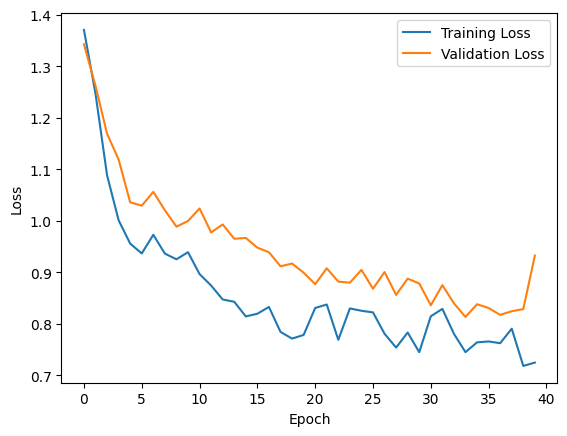

Test Accuracy: 43.17%


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇▁
test_accuracy,▁
train_loss,█▇▅▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▂▁▁
valid_loss,█▇▆▅▄▄▄▄▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▃
epoch,0
test_accuracy,43.1746
train_loss,0.72422
valid_loss,0.93196


wandb: Agent Starting Run: fqimfbso with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.146217771271996
wandb: 	epochs: 10
wandb: 	learning_rate: 0.00358978216463562
wandb: 	weight_decay: 0.0008590371755116395


FOLD 1
Epoch 1/10, Train Loss: 1.2467, Valid Loss: 1.1332
Epoch 2/10, Train Loss: 1.0066, Valid Loss: 0.9553
Epoch 3/10, Train Loss: 0.9384, Valid Loss: 0.9305
Epoch 4/10, Train Loss: 0.9780, Valid Loss: 1.0663
Epoch 5/10, Train Loss: 0.8998, Valid Loss: 0.8813
Epoch 6/10, Train Loss: 0.9201, Valid Loss: 1.0435
Epoch 7/10, Train Loss: 0.8689, Valid Loss: 0.9169
Epoch 8/10, Train Loss: 0.8317, Valid Loss: 0.7885
Epoch 9/10, Train Loss: 0.9013, Valid Loss: 0.9601
Epoch 10/10, Train Loss: 0.8863, Valid Loss: 0.8921
FOLD 2
Epoch 1/10, Train Loss: 0.8420, Valid Loss: 0.8089
Epoch 2/10, Train Loss: 0.7280, Valid Loss: 0.7342
Epoch 3/10, Train Loss: 0.7049, Valid Loss: 0.8302
Epoch 4/10, Train Loss: 0.8017, Valid Loss: 0.9278
Epoch 5/10, Train Loss: 0.7762, Valid Loss: 0.8231
Epoch 6/10, Train Loss: 0.7347, Valid Loss: 0.8304
Epoch 7/10, Train Loss: 0.7465, Valid Loss: 0.8446
Early stopping triggered
FOLD 3
Epoch 1/10, Train Loss: 0.7522, Valid Loss: 0.6781
Epoch 2/10, Train Loss: 0.6669, Val

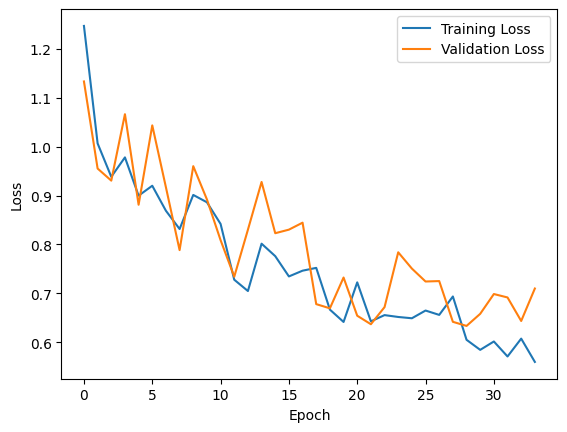

Test Accuracy: 40.00%


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▁▂▃▃▄▅▆▆▇█▁▁▂▃▃▄▅
test_accuracy,▁
train_loss,█▆▅▅▄▅▄▄▄▄▄▃▂▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁
valid_loss,█▆▅▇▄▇▅▃▆▅▃▂▄▅▄▄▄▂▂▂▁▁▂▃▃▂▂▁▁▁▂▂▁▂
epoch,5
test_accuracy,40
train_loss,0.56002
valid_loss,0.71003


wandb: Agent Starting Run: bw0doct3 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.1465603231560582
wandb: 	epochs: 10
wandb: 	learning_rate: 0.006027225196463771
wandb: 	weight_decay: 0.0008074519062161088


FOLD 1
Epoch 1/10, Train Loss: 1.3622, Valid Loss: 1.2923
Epoch 2/10, Train Loss: 1.1554, Valid Loss: 1.1130
Epoch 3/10, Train Loss: 0.9972, Valid Loss: 1.0167
Epoch 4/10, Train Loss: 0.9582, Valid Loss: 0.9764
Epoch 5/10, Train Loss: 0.8680, Valid Loss: 0.8646
Epoch 6/10, Train Loss: 0.8577, Valid Loss: 0.8679
Epoch 7/10, Train Loss: 0.8852, Valid Loss: 0.9888
Epoch 8/10, Train Loss: 0.9029, Valid Loss: 0.9092
Epoch 9/10, Train Loss: 0.8709, Valid Loss: 0.8436
Epoch 10/10, Train Loss: 0.8343, Valid Loss: 0.8862
FOLD 2
Epoch 1/10, Train Loss: 0.7943, Valid Loss: 0.8442
Epoch 2/10, Train Loss: 0.7603, Valid Loss: 0.8188
Epoch 3/10, Train Loss: 0.7530, Valid Loss: 0.8446
Epoch 4/10, Train Loss: 0.7632, Valid Loss: 0.8770
Epoch 5/10, Train Loss: 0.7628, Valid Loss: 0.8439
Epoch 6/10, Train Loss: 0.7338, Valid Loss: 0.8258
Epoch 7/10, Train Loss: 0.7557, Valid Loss: 0.8845
Early stopping triggered
FOLD 3
Epoch 1/10, Train Loss: 0.7340, Valid Loss: 0.6943
Epoch 2/10, Train Loss: 0.7089, Val

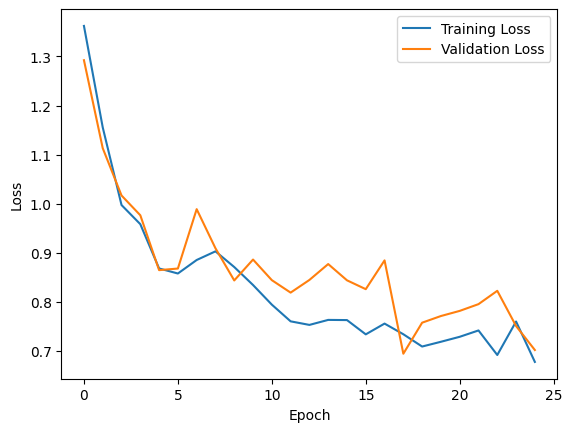

Test Accuracy: 43.81%


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▁▂▃▃▄▅▁▁
test_accuracy,▁
train_loss,█▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁
valid_loss,█▆▅▄▃▃▄▄▃▃▃▂▃▃▃▃▃▁▂▂▂▂▃▂▁
epoch,0
test_accuracy,43.80952
train_loss,0.67759
valid_loss,0.70182


In [16]:
wandb.agent(sweep_id, train, count=3)


---

---

---

# USING PRE-TRAINED MODEL

In [17]:
# initialize wandb
wandb.init(project="lung-cancer-classification-transfer", config={
    "learning_rate": 0.001,
    "epochs": 10,
    "batch_size": 32,
    "weight_decay": 1e-4,
    "dropout": 0.25,
    "architecture": "ResNet18",
    "dataset": "lung-cancer",
    "transfer_learning": True
})


In [18]:
# set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [19]:
# check if gpu is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # random resized crop
    transforms.RandomHorizontalFlip(p=0.2),  # horizontal flip
    transforms.RandomVerticalFlip(p=0.2),  # vertical flip
    transforms.ColorJitter(contrast=(0.8, 1.2)),  # contrast adjustment
    transforms.RandomRotation(30),  # rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transformation for validation and test data
valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [21]:
train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=train_transform)
valid_dataset = torchvision.datasets.ImageFolder(root=valid_folder, transform=valid_test_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_folder, transform=valid_test_transform)

# define the transfer learning model using resnet18


In [22]:
class TransferLearningModel(nn.Module):
    def __init__(self, num_classes=4):
        super(TransferLearningModel, self).__init__()
        # load pre-trained resnet18
        self.pretrained = torchvision.models.resnet18(weights='DEFAULT')

        # freeze all layers except the last few
        for param in self.pretrained.parameters():
            param.requires_grad = False

        # replace the last fully connected layer (classifier)
        num_features = self.pretrained.fc.in_features
        self.pretrained.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(wandb.config["dropout"]),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.pretrained(x)


In [23]:
# initialize the model
model = TransferLearningModel(num_classes=4).to(device)

print(model)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


TransferLearningModel(
  (pretrained): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

# loss function and optimizer (only for unfrozen parameters)


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=wandb.config["learning_rate"],
    momentum=0.9,
    weight_decay=wandb.config["weight_decay"]
)


# early stopping class


In [25]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def __call__(self, validation_loss):
        if (self.min_validation_loss - validation_loss) > self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif (self.min_validation_loss - validation_loss) <= self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopping = EarlyStopping(patience=5, min_delta=0)


# evaluate model before training


In [26]:
def evaluate_model(dataset, name="Test"):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in DataLoader(dataset, batch_size=wandb.config["batch_size"]):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'{name} Accuracy: {accuracy:.2f}%')
    return accuracy

print("\nEvaluating before training:")
initial_test_acc = evaluate_model(test_dataset, "Initial Test")
wandb.log({"initial_test_accuracy": initial_test_acc})



Evaluating before training:
Initial Test Accuracy: 13.97%


# k-fold cross validation


In [27]:
def train_model(train_loader, valid_loader):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
    valid_loss /= len(valid_loader)

    return train_loss, valid_loss


kfold = KFold(n_splits=5, shuffle=True)
train_losses, valid_losses = [], []

for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_dataset)):
    print(f'\nFOLD {fold + 1}')
    train_sampler = SubsetRandomSampler(train_ids)
    valid_sampler = SubsetRandomSampler(valid_ids)

    train_loader = DataLoader(train_dataset, batch_size=wandb.config["batch_size"], sampler=train_sampler)
    valid_loader = DataLoader(train_dataset, batch_size=wandb.config["batch_size"], sampler=valid_sampler)

    for epoch in range(wandb.config["epochs"]):
        train_loss, valid_loss = train_model(train_loader, valid_loader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "valid_loss": valid_loss,
            "fold": fold + 1
        })

        print(f'Epoch {epoch+1}/{wandb.config["epochs"]}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

        if early_stopping(valid_loss):
            print("Early stopping triggered")
            break




FOLD 1
Epoch 1/10, Train Loss: 1.3622, Valid Loss: 1.3449
Epoch 2/10, Train Loss: 1.1889, Valid Loss: 1.2051
Epoch 3/10, Train Loss: 1.0646, Valid Loss: 1.1052
Epoch 4/10, Train Loss: 0.9382, Valid Loss: 1.0435
Epoch 5/10, Train Loss: 0.9039, Valid Loss: 0.9293
Epoch 6/10, Train Loss: 0.8710, Valid Loss: 0.8382
Epoch 7/10, Train Loss: 0.8095, Valid Loss: 0.8761
Epoch 8/10, Train Loss: 0.7965, Valid Loss: 0.7860
Epoch 9/10, Train Loss: 0.7551, Valid Loss: 0.7606
Epoch 10/10, Train Loss: 0.8015, Valid Loss: 0.8460

FOLD 2
Epoch 1/10, Train Loss: 0.7700, Valid Loss: 0.6616
Epoch 2/10, Train Loss: 0.7588, Valid Loss: 0.8007
Epoch 3/10, Train Loss: 0.7308, Valid Loss: 0.7184
Epoch 4/10, Train Loss: 0.6552, Valid Loss: 0.6952
Epoch 5/10, Train Loss: 0.6425, Valid Loss: 0.7696
Epoch 6/10, Train Loss: 0.6758, Valid Loss: 0.6228
Epoch 7/10, Train Loss: 0.6249, Valid Loss: 0.5823
Epoch 8/10, Train Loss: 0.6123, Valid Loss: 0.6855
Epoch 9/10, Train Loss: 0.6451, Valid Loss: 0.7603
Epoch 10/10, T

# plot training and validation loss


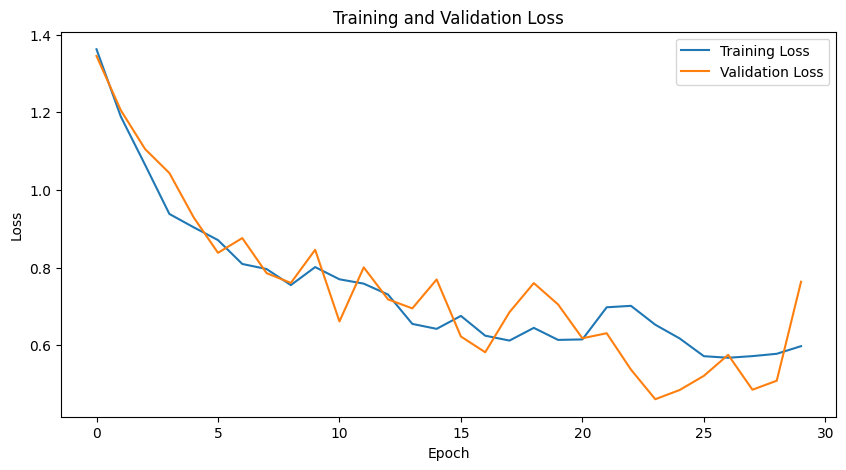

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [29]:
print("\nEvaluating after training:")
final_test_acc = evaluate_model(test_dataset, "Final Test")
wandb.log({"final_test_accuracy": final_test_acc})

# calculate improvement
improvement = final_test_acc - initial_test_acc
print(f'\nImprovement after training: {improvement:.2f}%')
wandb.log({"accuracy_improvement": improvement})



Evaluating after training:
Final Test Accuracy: 51.43%

Improvement after training: 37.46%


In [30]:
# save model
torch.save(model.state_dict(), 'lung_cancer_resnet18.pth')
print("Model saved to lung_cancer_resnet18.pth")


Model saved to lung_cancer_resnet18.pth


In [31]:
wandb.finish()

accuracy_improvement,▁
epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█▁▂▁▂▃▃▄▅▆▁
final_test_accuracy,▁
fold,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▆▆▆▆▆▆▆█
initial_test_accuracy,▁
train_loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁
valid_loss,█▇▆▆▅▄▄▄▃▄▃▄▃▃▃▂▂▃▃▃▂▂▂▁▁▁▂▁▁▃
accuracy_improvement,37.46032
epoch,0
final_test_accuracy,51.42857
fold,5
